# An update on the loaded climate dice

One of the recurring claims you will find in discussions of climate change is that the climate in general not only becomes warmer but also more extreme. For instance, the latest report on climate change by the U.S. Administration is covered in the news as follows:

> "While summers become more extreme, the harshness of winter is expected to ease." (Jason Samenow, [Washington Post, November 27](https://www.washingtonpost.com/weather/2018/11/27/weather-washingtons-future-hellish-heat-high-water-says-trump-administration-climate-report/?noredirect=on&utm_term=.7edba1564483)) 

In the last post, I have replicated a paper (Hansen et al. 2012) that shows in an elegant (because easy to see) way that the average temperatures during summer indeed rise (see [here](https://mschermann.github.io/serendipity/posts/loaded-climate-dice/)). Interestingly, there is a response (Rhines and Huybers 2013) to this paper that argues that while the average temperatures rise, they do not become more extreme. 

In other words, the mean of summer temperatures rises but the variance of the temperatures remains stable. The authors of the response suggest a series of corrections to show that the variance remains stable. I have replicated some of the corrections in my previous post. 

A big difference between my replication attempt and the papers by Hansen et al. (2012) and Rhines and Huybers (2013) is that I use the actual station data while the two papers use a gridded composition of the station data. Each grid represents a 250km square.

Using the actual station data instead the gridded data has some implications:
* An increase or decreased in available stations does not affect the results from the individual stations but will affect the gridded data.
* The gridded data is also influenced by covariances between the stations while the individual station data is not. 
* Systematic measurement errors in one station do not get smoothed out. Thus, faulty stations may affect the results to a higher degree when compared to the gridded data.


Here, I will replicate the results again and in addition to the corrections applied in the previous post, I will focus on the following issues:
* Use stations that report temperature data on the full timeperiod between 1950 to today.
* Detrend the temperature data for each station to correct for trend-induced variance components. 


## Setup

Lets' set up our environment to allow [multiple outputs](https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs) for each code cell. Also, we use the [magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html) command to display [matplotlib](https://matplotlib.org) plots in the Jupyter notebook.

In [1]:
# Multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# Show matplotlib plots inline
%matplotlib inline
import matplotlib.pyplot as plt

For data wrangling, we use the [Pandas](http://pandas.pydata.org) library, one of the most versatile workhorses for data analytics. Additionally, we need the [NumPy](http://www.numpy.org) library for general scientific computing. 

Scipy

In [2]:
import pandas as pd
import numpy as np

We format the display of rows and the number of decimals. _(These commands setup Jupyter to my personal preferences. They are not required.)_

In [3]:
# Display up to 500 rows at a time
pd.set_option('display.max_rows', 500)
# Format the display of numbers to two decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Furthermore, we use [altair](https://altair-viz.github.io) to render visualizations.

In [4]:
import altair as alt
#Render altair charts inline 
alt.renderers.enable('notebook') # Change this depending on where you run the notebook.

RendererRegistry.enable('notebook')

## Data Cleaning

Let's read the data. We use the same data as in the previous post.

In [5]:
raw = pd.read_csv('https://raw.githubusercontent.com/mschermann/loaded_climate_dice/master/step2.v3.csv', header=None)
raw.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,101603550000,1966,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,1374,1144
1,101603550000,1967,1044,1164,1334,1474,1854,1974,2434,2594,2294,2054,1704,1114
2,101603550000,1968,1134,1274,1344,1644,1854,2114,2514,2454,2274,1954,1664,1324
3,101603550000,1969,1214,1184,1384,1534,1864,1984,2274,2454,2244,1894,1654,1124
4,101603550000,1970,1334,1144,1264,1424,1694,2154,2364,2534,2374,-9999,1524,1186


We create a copy of the data, note missing values (-9999 in the dataset), and drop all missing values to ensure that we have only complete yearly datasets. Finally, we rename the columns to interpreting the data easier.

In [6]:
data = raw.copy()
data = data.replace(-9999,np.NaN)
data = data.dropna()
data.columns = ['station_id','year',\
               'jan','feb','mar','apr',\
               'may','jun','jul','aug',\
               'sep','oct','nov','dec']

We also include the location of each station to make sure that we only analyze stations on the Northern hemisphere.

In [7]:
colspecs = [(0,11),(12,42),(43,49),(50,57)]
stations = pd.read_fwf('https://raw.githubusercontent.com/mschermann/loaded_climate_dice/master/v3.temperature.inv.txt', colspecs=colspecs, names=['station_id', 'name', 'lat', 'lon'], header=None, index_col=0, skiprows=40).reset_index()

There is a formatting mismatch for the `station_id`'s between the location data and the temperature data.

In [8]:
#https://stackoverflow.com/questions/33034559/how-to-remove-last-the-two-digits-in-a-column-that-is-of-integer-type
data['station_id'] = data['station_id'].astype(str).str[:-1].astype(np.int64)

Now, we can merge the temperature data with the location data.

In [9]:
loc_data = pd.merge(data, stations, how='left', left_on='station_id', right_on='station_id')

This allows us to filter the data to include only stations on the Northern hemisphere, that is where the latitude is positive.

In [10]:
loc_data = loc_data[loc_data['lat']>0].copy()

## The number of stations over time

An important issue is that the number of stations that are included in the analysis, significantly varies over time. The following chart visualizes this problem.



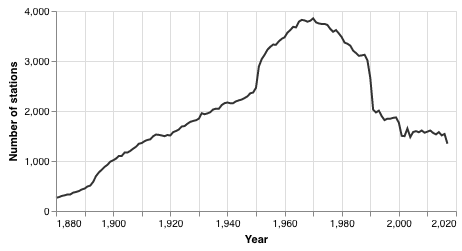

In [11]:
alt.Chart(loc_data.groupby('year')['station_id'].count().reset_index()).mark_line(color='#333').encode(
    x=alt.X('year:Q', axis=alt.Axis(title='Year')),
    y=alt.Y('station_id:Q', axis=alt.Axis(title='Number of stations')),
).properties(
    width=400,
    height=200
)

As you can see, after an almost linear growth, we have a significant increase of temperature stations between 1950 and 1970. Then, between 1970 and 1990 the number of available stations decreases. Around 1990, we have a sudden drop in the number of stations. Since about 2000, the number of stations remains fairly stable at a level that is similar to the 1920s (!).

Obviously, the number of available stations that we either directly analyze or that goes into the gridded data influences the results. The fewer measurements we have per station, the larger is the impact of measurement errors, random noise, and other issues. 

Thus, we limit our analysis to stations that meet the following requirements:
* We drop all missing data. We assume that stations that have missing data may have been affected by technical or political issues. We have already dropped all missing values in code cell `6` above.
* We only include stations that have at least 65 measurements during the timeperiod of 1950 and 2017. This means, that stations with more than two years missing will be excluded from the analyis. 

We focus on the range of years analyzed by Hansen et al. (2012)

In [12]:
relevant_years = list(range(1950,2018))

We filter the data to include on the relevant years.

In [13]:
cd = loc_data[loc_data['year'].isin(relevant_years)]

We count the number of available years for each station.

In [14]:
cs = cd.groupby('station_id')['year'].count().reset_index()

We set the threshold to 65 years.

In [15]:
threshold = 65

We filter our data accordingly.

In [16]:
complete = cd[cd['station_id'].isin(cs[cs['year']>=threshold]['station_id'])]

In [17]:
len(complete['station_id'].unique())

205

On the Northern hemisphere, only 205 stations report complete data for at least 65 years between 1950 and 2017. The following map shows the locations of the 205 stations.

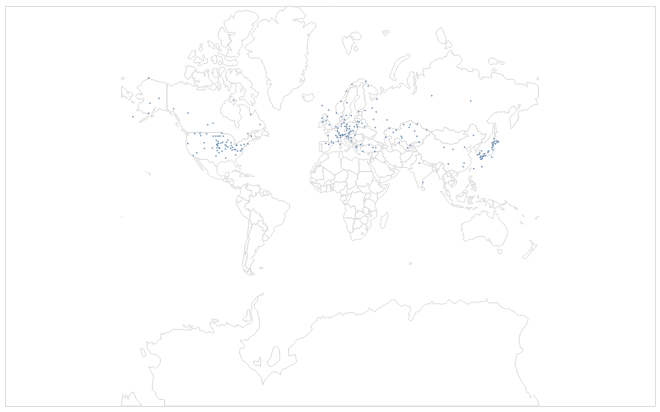

In [18]:
from vega_datasets import data

countries = alt.topo_feature(data.world_110m.url, 'countries')

base = alt.Chart(countries).mark_geoshape(
     fill='#FFFFFF',
     stroke='666666'
)

stations = alt.Chart(complete.groupby('station_id')[['station_id', 'name', 'lat', 'lon']].agg('first')).mark_circle(size=3).encode(
    longitude='lon:Q',
    latitude='lat:Q',
).project(
    type='mercator'
).properties(
    width=650,
    height=400
)

base + stations

As we can see, most of the stations are in the US, Europe, and Japan. Very few stations report data on Canada, Russia, China, and India. The map alludes to a potential issue. The visible gaps in the available data means that we have almost no information on Canada, Russia, China, and India, which represent large areas of the planet. Thus, we should be careful about 'global' statements.

## Distance between stations

Nevertheless, the data is what it is. Another issue could be that the stations are too close to each other, which could result in co-variances in the gridded data.

In the following, we analyze the distances between the stations.

We get a list of the stations, their names, and their location.

In [19]:
s_l = complete.groupby('station_id')[['name', 'lat', 'lon']].agg('first').reset_index()

In [20]:
s_l.head()

,station_id,name,lat,lon
0,20550745000,QIQIHAR,47.38,123.92
1,20552533000,JIUQUAN,39.77,98.48
2,20553614000,YINCHUAN,38.48,106.22
3,20554511000,BEIJING,39.93,116.28
4,20556571000,XICHANG,27.90,102.27


We calculate the neighbors for each station.

In [21]:
from scipy import spatial
s_coords = s_l[['lat','lon']].values
neighbors = spatial.KDTree(s_coords)

The following functions extracts the second-nearest station from the neighbors data (The nearest station would be the station itself) and returns the station name and the distance in kilometers.

In [22]:
#https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
import geopy.distance

def get_nearest_station_and_distance(x):
    #print(x)
    d, i = neighbors.query([x['lat'],x['lon']], k=2)
    n = s_coords[i[1]]
    #print(n[0], n[1])
    station_id = s_l[(s_l['lat']==n[0]) & (s_l['lon']==n[1])]['station_id'].iloc[0]
    #print(station_id)
    #print(geopy.distance.distance([x['lat'],x['lon']], n).km)
    return pd.Series([station_id, geopy.distance.distance([x['lat'],x['lon']], n).km])

We add the closest neighbor and the neighbor's distance to the station data.

In [23]:
s_l[['neighbor','distance']] = s_l.apply(lambda x: get_nearest_station_and_distance(x), axis=1)

In [24]:
s_l['distance'].describe()
s_l['distance'].median()

count    205.00
mean     294.15
std      297.29
min       13.75
25%      128.92
50%      184.83
75%      330.88
max     1830.19
Name: distance, dtype: float64

184.83280950507566

On average, the stations are 294.15 km apart. However, the median is just 184.83 km. This means that we have a lot of stations that cluster and some stations that have very far away neighbors. We have to keep in mind that this may influence the results. 

# Replication

Now, we have a better understanding of the where the data comes from. We prepare the data.

We create a copy of the station data.

In [25]:
c_d = complete.copy()

We calculate the mean temperature for the summer months as proposed by Hansen et al. (2012).

In [26]:
c_d['jja'] = c_d[['jun','jul', 'aug']].mean(axis=1)

We focus the dataset on the relevant columns.

In [27]:
c_d = c_d.loc[:,['station_id', 'year', 'jja', 'name', 'lat', 'lon']].copy()

## Detrending

In the previous post, I have omitted the detrending correction of the data suggested by Rhines and Huybers (2013). [Detrending](http://www.stochtastic.com/climate-variability-and-extremes.html) did not appear to make a significant impact. However, since we only have the station data that reports over 65 years, the trend may actually increase the variance. 

The [`scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) package offers a simple lineare detrending algorithm. 

In [28]:
#https://stackoverflow.com/questions/43544895/warning-using-scipy-with-pandas
from scipy import signal
# We need this to avoid a warning message for the LAPACK package.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

detr = pd.DataFrame(c_d.groupby('station_id')['jja'].\
transform(lambda x: signal.detrend(x)))

We rename the detrended summer temperatures as `detr`.

In [29]:
detr.rename(columns={'jja':'detr'}, inplace=True)

We add the detrended temperatures to the station data.

In [30]:
cdata = pd.merge(c_d, detr, how='left', \
                 left_index=True, right_index=True)

In [31]:
cdata.head()

,station_id,year,jja,name,lat,lon,detr
17908,20550745000,1950,2263.33,QIQIHAR,47.38,123.92,163.87
17909,20550745000,1951,2120.00,QIQIHAR,47.38,123.92,18.31
17910,20550745000,1952,2170.00,QIQIHAR,47.38,123.92,66.07
17911,20550745000,1953,2193.33,QIQIHAR,47.38,123.92,87.17
17912,20550745000,1954,2143.33,QIQIHAR,47.38,123.92,34.94


The detrended data appears to be completely different from the original data. To better understand the effect of detrending, the following chart compares the actual and the detrended data for station `20550745000`.

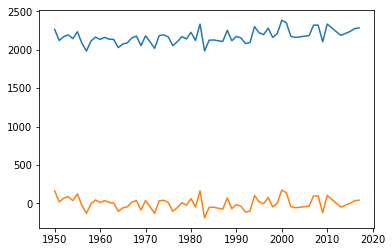

In [32]:
plt.plot(cdata[cdata['station_id']==20550745000]['year'], \
         cdata[cdata['station_id']==20550745000]['jja'])
plt.plot(cdata[cdata['station_id']==20550745000]['year'], \
         cdata[cdata['station_id']==20550745000]['detr'])
plt.show;

As we can see, the pattern of the data the same. The only difference is that the 'slight' upward trend is removed. The impact of the trend on the variance for this station is as follows.

In [33]:
round((cdata[cdata['station_id']==20550745000]['detr'].var() - \
 cdata[cdata['station_id']==20550745000]['jja'].var()) / \
 cdata[cdata['station_id']==20550745000]['jja'].var(), 2)

-0.23

The variance for this station decreased by 23 percent.

In [34]:
var_overall = cdata.groupby('station_id')[['jja', 'detr']].var().reset_index()

In [35]:
round((var_overall['detr'].mean() - var_overall['jja'].mean())/var_overall['jja'].mean(),2)

-0.16

Overall, detrending the data reduced the variance of the stations by 16 percent. However, this is across the whole dataset. Rhines and Huybers (2013) suggest to detrend for each timeperiod. This would be particularly important if the trend for the average temperature accelerates. 

## Corrected z-scores

Following Hansen et al. (2012) and Rhines and Huybers (2013), we analyze the following  timeperiods:
1. A baseline period that covers the years between 1950 and 1979.
2. A comparison period that covers the years between 1980 and 2009.
3. We add a third timeperiod that covers the years between 2010 and today.
4. We analyze each decade since 1980 independently.

In contrast to Hansen et al. (2012), we shift the timeperiod by one year to include the year 1950).

For each station, we calculate the following information:
* We calculate the mean temperature for the baseline period.
* We calculate the standard deviation for each period independently.
* We detrend the data for each period independently.

### Baseline

In [36]:
base = cdata[(cdata['year']>=1950) & (cdata['year']<1980)].copy().\
groupby('station_id')[['jja', 'detr']].\
agg({'jja': ['mean','std'], 'detr': ['std']}).reset_index()
base.columns = base.columns.map('_'.join)
base = base.rename(columns={'station_id_':'station_id'})

In [37]:
base.head()

,station_id,jja_mean,jja_std,detr_std
0,20550745000,2130.44,63.52,69.74
1,20552533000,2087.86,83.51,90.23
2,20553614000,2208.67,65.21,75.88
3,20554511000,2520.12,75.30,77.19
4,20556571000,2186.88,57.88,57.26


### 1980 to 2010

In [38]:
sd_2010 = cdata[(cdata['year']>=1980) & (cdata['year']<2010)].copy().\
groupby('station_id')[['jja', 'detr']].\
agg({'jja': ['mean','std'], 'detr': ['std']}).reset_index()
sd_2010.columns = sd_2010.columns.map('_'.join)
sd_2010 = sd_2010.rename(columns={'station_id_':'station_id'})

### 2010 to today

In [39]:
sd_today = cdata[(cdata['year']>=2010)].copy().\
groupby('station_id')[['jja', 'detr']].\
agg({'jja': ['mean','std'], 'detr': ['std']}).reset_index()
sd_today.columns = sd_today.columns.map('_'.join)
sd_today = sd_today.rename(columns={'station_id_':'station_id'})

### Decades since 1950

In [40]:
decades = cdata.copy()
#https://stackoverflow.com/questions/48856982/divide-data-by-decade-then-plot-it-seaborn-box-and-whisker
decades['decade'] = (decades['year'] // 10) * 10

In [41]:
sd_decades = decades.\
groupby(['station_id','decade'])[['jja', 'detr']].\
agg({'jja': ['mean','std'], 'detr': ['std']}).reset_index()
sd_decades.columns = sd_decades.columns.map('_'.join)
sd_decades = sd_decades.rename(columns={'station_id_':'station_id', 'decade_':'decade'})

In [42]:
sd_decades.head()

,station_id,decade,jja_mean,jja_std,detr_std
0,20550745000,1950,2146.67,79.33,82.86
1,20550745000,1960,2113.67,49.88,51.80
2,20550745000,1970,2131.00,60.12,60.25
3,20550745000,1980,2150.67,96.72,97.96
4,20550745000,1990,2186.67,71.02,68.49


### Combine the data

In [43]:
c = pd.merge(cdata, base, how='left', on='station_id')
c = pd.merge(c, sd_2010, how='left', on='station_id', suffixes=('_base', '_2010'))
c = pd.merge(c, sd_today, how='left', on='station_id', suffixes=('_2010', '_today'))

In [44]:
c['decade'] = (c['year'] // 10) * 10

In [45]:
c = pd.merge(c, sd_decades, how='left', on=['station_id', 'decade'], suffixes=('_today', '_decade') )

In [46]:
c.head()

,station_id,year,jja,name,lat,lon,detr,jja_mean_base,jja_std_base,detr_std_base,jja_mean_2010,jja_std_2010,detr_std_2010,jja_mean_today,jja_std_today,detr_std_today,decade,jja_mean_decade,jja_std_decade,detr_std_decade
0,20550745000,1950,2263.33,QIQIHAR,47.38,123.92,163.87,2130.44,63.52,69.74,2191.67,96.34,91.24,2261.43,47.02,48.56,1950,2146.67,79.33,82.86
1,20550745000,1951,2120.00,QIQIHAR,47.38,123.92,18.31,2130.44,63.52,69.74,2191.67,96.34,91.24,2261.43,47.02,48.56,1950,2146.67,79.33,82.86
2,20550745000,1952,2170.00,QIQIHAR,47.38,123.92,66.07,2130.44,63.52,69.74,2191.67,96.34,91.24,2261.43,47.02,48.56,1950,2146.67,79.33,82.86
3,20550745000,1953,2193.33,QIQIHAR,47.38,123.92,87.17,2130.44,63.52,69.74,2191.67,96.34,91.24,2261.43,47.02,48.56,1950,2146.67,79.33,82.86
4,20550745000,1954,2143.33,QIQIHAR,47.38,123.92,34.94,2130.44,63.52,69.74,2191.67,96.34,91.24,2261.43,47.02,48.56,1950,2146.67,79.33,82.86


We calculate the z-score based on the mean of the timeperiod 1950 to 1979 and the corrected standard deviations.

In [47]:
c['z_base'] = (c['jja']-c['jja_mean_base'])/c['jja_std_base']
c['z_base_detr'] = (c['jja']-c['jja_mean_base'])/c['detr_std_base']

c['z_2010'] = (c['jja']-c['jja_mean_base'])/c['jja_std_2010']
c['z_2010_detr'] = (c['jja']-c['jja_mean_base'])/c['detr_std_2010']

c['z_today'] = (c['jja']-c['jja_mean_base'])/c['jja_std_today']
c['z_today_detr'] = (c['jja']-c['jja_mean_base'])/c['detr_std_today']

c['z_decade'] = (c['jja']-c['jja_mean_base'])/c['jja_std_decade']
c['z_decade_detr'] = (c['jja']-c['jja_mean_base'])/c['detr_std_decade']

In [48]:
c[(c['year']>=1950) & (c['year']<1980)]['z_base_detr'].std()

0.9535222321978685

## Histograms

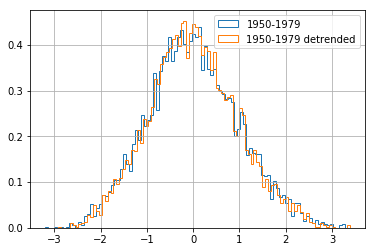

In [49]:
c[(c['year']>=1950) & (c['year']<1980)]['z_base'].\
hist(bins=100, histtype = 'step', label='1950-1979', density=True)
c[(c['year']>=1950) & (c['year']<1980)]['z_base_detr'].\
hist(bins=100, histtype = 'step', label='1950-1979 detrended', density=True).legend(loc='upper right');

In [50]:
import scipy.stats as sc
sc.levene(c[(c['year']>=1950) & (c['year']<1980)]['z_base'],\
          c[(c['year']>=1950) & (c['year']<1980)]['z_base_detr'], \
          center='median')

LeveneResult(statistic=5.546793459057612, pvalue=0.01853043483528889)

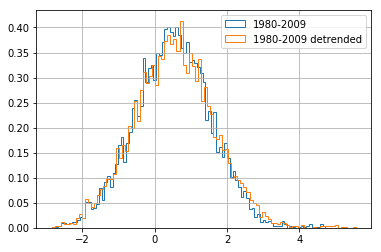

In [51]:
c[(c['year']>=1980) & (c['year']<2010)]['z_2010'].\
hist(bins=100, histtype = 'step', label='1980-2009', density=True)
c[(c['year']>=1980) & (c['year']<2010)]['z_2010_detr'].\
hist(bins=100, histtype = 'step', label='1980-2009 detrended', density=True).legend(loc='upper right');

In [52]:
sc.levene(c[(c['year']>=1980) & (c['year']<2010)]['z_2010'],\
          c[(c['year']>=1980) & (c['year']<2010)]['z_2010_detr'], \
          center='median')

LeveneResult(statistic=13.85822971800873, pvalue=0.0001980359268578363)

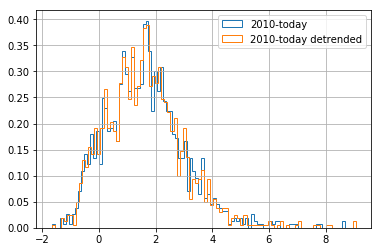

In [53]:
c[(c['year']>=2010)]['z_today'].\
hist(bins=100, histtype = 'step', label='2010-today', density=True)
c[(c['year']>=2010)]['z_today_detr'].\
hist(bins=100, histtype = 'step', label='2010-today detrended', density=True).legend(loc='upper right');

In [54]:
sc.levene(c[(c['year']>=2010)]['z_today'],\
          c[(c['year']>=2010)]['z_today_detr'], \
          center='median')

LeveneResult(statistic=0.08046936794091337, pvalue=0.7766818395331387)

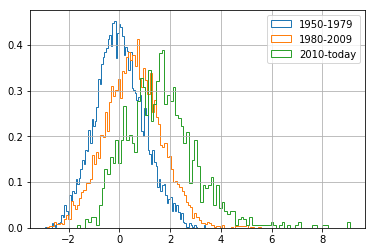

In [55]:
c[(c['year']>=1950) & (c['year']<1980)]['z_base_detr'].\
hist(bins=100, histtype = 'step', label='1950-1979', density=True)
c[(c['year']>=1980) & (c['year']<2010)]['z_2010_detr'].\
hist(bins=100, histtype = 'step', label='1980-2009', density=True)
c[(c['year']>=2010)]['z_today_detr'].\
hist(bins=100, histtype = 'step', label='2010-today', density=True).legend(loc='upper right');

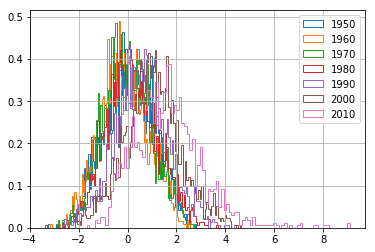

In [56]:
c[c['decade']==1950]['z_decade_detr'].\
hist(bins=100, histtype = 'step', label='1950', density=True)
c[c['decade']==1960]['z_decade_detr'].\
hist(bins=100, histtype = 'step', label='1960', density=True)
c[c['decade']==1970]['z_decade_detr'].\
hist(bins=100, histtype = 'step', label='1970', density=True)
c[c['decade']==1980]['z_decade_detr'].\
hist(bins=100, histtype = 'step', label='1980', density=True)
c[c['decade']==1990]['z_decade_detr'].\
hist(bins=100, histtype = 'step', label='1990', density=True)
c[c['decade']==2000]['z_decade_detr'].\
hist(bins=100, histtype = 'step', label='2000', density=True)
c[c['decade']==2010]['z_decade_detr'].\
hist(bins=100, histtype = 'step', label='2010', density=True).legend(loc='upper right');

## Observations

We calculated independent standard deviations and detrended the station data. Still, the variance of the temperature data increases.

In [57]:
c[(c['year']>=1950) & (c['year']<1980)]['z_base_detr'].var()
c[(c['year']>=1980) & (c['year']<2010)]['z_2010_detr'].var()
c[(c['year']>=2010)]['z_today_detr'].var()

0.9092046472956058

1.2324471771152585

1.9358749526135184

The kurtosis of the distributions suggest that we can expect longer tails (more extreme temperature events). This is also visible in the histograms.

In [58]:
c[(c['year']>=1950) & (c['year']<1980)]['z_base_detr'].kurtosis()
c[(c['year']>=1980) & (c['year']<2010)]['z_2010_detr'].kurtosis()
c[(c['year']>=2010)]['z_today_detr'].kurtosis()

-0.1271642452398214

0.3400526263141632

2.277009331459607

Additionally, the increasing positive skewness sugges that we we can expect more extreme hot temperatures than more extreme cold temperatures.  This is also visible in the histograms.

In [59]:
c[(c['year']>=1950) & (c['year']<1980)]['z_base_detr'].skew()
c[(c['year']>=1980) & (c['year']<2010)]['z_2010_detr'].skew()
c[(c['year']>=2010)]['z_today_detr'].skew()

0.16540508431056408

0.16188363599745012

0.9150190198457407

We see a similar trend in the decade data.

In [60]:
#https://stackoverflow.com/questions/37345493/kurtosis-on-pandas-dataframe-doent-work
stats = c.groupby('decade')['z_decade_detr'].agg(['mean', 'var', pd.DataFrame.kurt, 'skew']).reset_index()

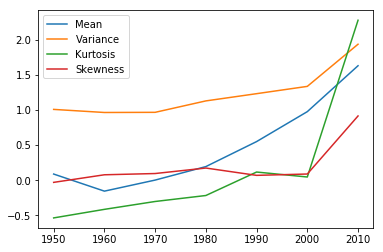

In [61]:
plt.plot(stats['decade'], stats['mean'], label='Mean')
plt.plot(stats['decade'], stats['var'], label = 'Variance')
plt.plot(stats['decade'], stats['kurt'], label = 'Kurtosis')
plt.plot(stats['decade'], stats['skew'], label = 'Skewness')
plt.legend(loc='upper left');
plt.show();

We see that the dramatic effects are primarily a result of the last two decades (2000-2010 and 2010 to today).

## Rival explanations

One issues could be that there a certain set of stations that influence the result.

We calculate the stations in the timeperiods between 1980 and 2009 and 2010 and today that have temperature measurements that are more than 3 standard deviations away from the mean.

In [62]:
out_base = c[(c['year']>=1950) & \
             (c['year']<1980) & \
             (c['z_base_detr'] > (c['z_base_detr'].mean() + c['z_base_detr'].std()*3))]
out_2010 = c[(c['year']>=1980) & \
             (c['year']<2010) & \
             (c['z_2010_detr'] > (c['z_2010_detr'].mean() + c['z_2010_detr'].std()*3))]
out_today = c[(c['year']>=2010) & \
              (c['z_today_detr'] > (c['z_today_detr'].mean() + c['z_2010_detr'].std()*3))]

In [63]:
len(out_base.station_id.unique())
len(out_2010.station_id.unique())
len(out_today.station_id.unique())

0

24

45

There are no outlier station in the baseline, 24 outliers in the timeperiod 1980 to 2009, and 45 outliers in the timeperiod 2010 to today.

In [64]:
o_2010 = out_2010.groupby('station_id')['year'].agg(['count','min', 'max']).reset_index()
o_today = out_today.groupby('station_id')['year'].agg(['count','min', 'max']).reset_index()

In [65]:
o_2010_2 = o_2010[o_2010['count']>=2]
len(o_2010_2.station_id.unique())

0

In the timeperiod 1980 to 2009, no station reports more than one extreme event. This may indicate measurement errors or outlying events.

In [66]:
o_today_2 = o_today[o_today['count']>=2]
len(o_today_2.station_id.unique())

20

In the timeperiod 2010 to today, there are 20 stations that report at least two exteme events.

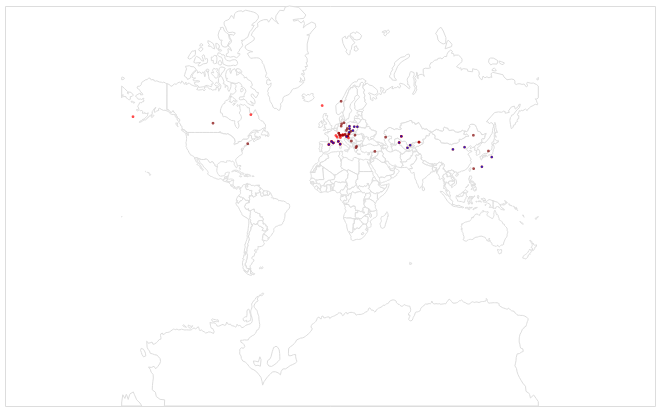

In [67]:
from vega_datasets import data

countries = alt.topo_feature(data.world_110m.url, 'countries')

base = alt.Chart(countries).mark_geoshape(
     fill='#FFFFFF',
     stroke='666666'
)

stations_2010_1 = alt.Chart(out_2010[out_2010['station_id'].\
                              isin(o_2010['station_id'])].\
                          groupby('station_id')[['station_id', 'name', 'lat', 'lon']].\
                          agg('first')).mark_circle(fill='#ff0000', size=8).\
encode(
    longitude='lon:Q',
    latitude='lat:Q',
).project(
    type='mercator'
).properties(
    width=650,
    height=400
)

stations_today_1 = alt.Chart(out_today[out_today['station_id'].\
                              isin(o_today['station_id'])].\
                          groupby('station_id')[['station_id', 'name', 'lat', 'lon']].\
                          agg('first')).mark_circle(fill='#800000', size=8).\
encode(
    longitude='lon:Q',
    latitude='lat:Q',
).project(
    type='mercator'
).properties(
    width=650,
    height=400
)

stations_today_2 = alt.Chart(out_today[out_today['station_id'].\
                               isin(o_today_2['station_id'])].\
                           groupby('station_id')[['station_id', 'name', 'lat', 'lon']].\
                           agg('first')).mark_circle(fill='#0000ff', size=4).\
encode(
    longitude='lon:Q',
    latitude='lat:Q',
).project(
    type='mercator'
).properties(
    width=650,
    height=400
)

base + stations_2010_1 + stations_today_1 + stations_today_2

This map suggests that extreme events occur mostly in Europe and Asia along similar latitudes.

In [68]:
round(out_2010[out_2010['station_id'].isin(o_2010['station_id'])].\
                          groupby('station_id')[['station_id', 'name', 'lat', 'lon']].\
                          agg('first')['lat'].mean(),2)
round(out_today[out_today['station_id'].isin(o_today['station_id'])].\
                          groupby('station_id')[['station_id', 'name', 'lat', 'lon']].\
                          agg('first')['lat'].mean(),2)
round(out_today[out_today['station_id'].isin(o_today_2['station_id'])].\
                           groupby('station_id')[['station_id', 'name', 'lat', 'lon']].\
                           agg('first')['lat'].mean(),2)

47.39

45.33

43.76

The average latitude ranges between 47.39 and 43.13 degrees latitude.

## Final thoughts

In an addition to the [previous post](https://mschermann.github.io/serendipity/posts/loaded-climate-dice/), we corrected the data for biases due to trends and analyzed only complete station data. Although both corrections reduce the variances but the data suggest that the variance still rises. The rise in variance seems to be induced by extreme temperature events of a few stations between 47.39 and 43.13 degrees latitude. These surface areas include the hottest areas on Earth. Only few extreme events are in North America. Thus, we can assume that here the weather gets hotter but not more extreme. A next analysis could focus only on the United States. Additionally, the analysis of the gridded temperature data could smooth over the extreme events in specific stations. But, this is something for another post, too.

## Literature

* Hansen, Sato, Ruedy (2012): [Perception of Climate Change](http://www.pnas.org/content/109/37/E2415). Proceedings of the National Academy of Sciences, 109(37) E2415-E2423; DOI: [10.1073/pnas.1205276109](https://doi.org/10.1073/pnas.1205276109)
* Rhines and Huybers (2013): [Frequent summer temperature extremes reflect changes in the mean, not the variance](http://www.pnas.org/content/110/7/E546), Proceedings of the National Academy of Sciences, 110(7) E546; DOI: [10.1073/pnas.1218748110](https://doi.org/10.1073/pnas.1218748110)

This project (including the data as of October 10, 2018) is available at [https://github.com/mschermann/loaded_climate_dice](https://github.com/mschermann/loaded_climate_dice).